In [1]:
#loading important packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import glob
import gensim

C:\Users\minha\Anaconda3\lib\site-packages\gensim\similarities\__init__.py:15: UserWarning: The gensim.similarities.levenshtein submodule is disabled, because the optional Levenshtein package <https://pypi.org/project/python-Levenshtein/> is unavailable. Install Levenhstein (e.g. `pip install python-Levenshtein`) to suppress this warning.
  warnings.warn(msg)


In [4]:
#important changes to save the plots
import time

saving_path="C:/Users/minha/Desktop/plots_new/updated/"
font = {'family' : "Times New Roman",
         'weight' : 'normal',
         'size'   : 10}
plt.rc('font', **font)

In [2]:
##reading meatadata from excel files
import os
path = r'C:\Users\minha\Desktop\Thesis\scripts\FH'
file_list = glob.glob(os.path.join(path, "*.xls"))
li = []
for file in file_list:
    df = pd.read_excel(file)
    li.append(df)
wos_df = pd.concat(li,axis=0,ignore_index = True) #include all books and journals
wos=wos_df.astype(str)

#wos = wos_df[wos_df['Publication Type']=="J"].astype(str) ## taking only thee Journals and articles.
#wos = wos[wos["Publication Year"]=="2020.0"]
#wos.to_pickle("wos.pkl") #saving intidal datframe as pickle

In [3]:
#numbers changing to float
wos["Publication Year"]=wos["Publication Year"].fillna(wos['Early Access Date'].str[3:8]).astype("float")
wos["Publication Year"]=wos["Publication Year"].fillna(wos['Early Access Date'].str[3:8]).astype("float")
wos=wos.sort_values("Publication Year")

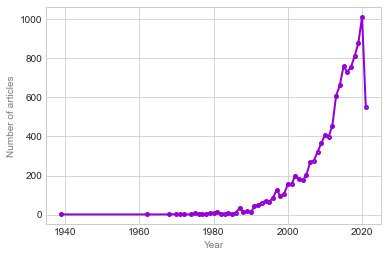

In [5]:
#Plotting line plots for number of artciles per year
wos["Publication Year"] = wos["Publication Year"].astype(float)

#extract = wos[(wos['Publication Year']>=1990)&(wos['Publication Year']<2020)].reset_index(drop=True)
table = wos.groupby(["Publication Year"]).count()

%matplotlib inline
plt.style.use('seaborn-whitegrid')
plt.plot(table.index, table["Abstract"], marker='.', linestyle='solid', mfc='none', mec='darkviolet',color='darkviolet',linewidth=2,
        mew=2)
plt.xlabel("Year",alpha=0.6)
plt.ylabel("Number of articles",alpha=0.6)
#plt.legend("coherence_values", loc='best')
#plt.savefig(saving_path+"numberofarticles_"+ time.strftime("%Y-%m-%d %H%M%S") + ".png",dpi=300)
plt.show()

### CLEANING PHASE : 1

In [6]:
##text cleaning 1
import re
import string
def text_cleaning1(text):
    '''Make text lowercase, remove text in square brackets, remove punctuation and remove words containing numbers.'''
    text = text.lower()
    text = re.sub('\[.*?\]', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\w*\d\w*', '', text)
    text = re.sub('[‘’“”…]', '', text)
    text = re.sub('\n', '', text)
    text = re.sub('nan','',text)
    return text
phase1 = lambda x: text_cleaning1(x)

In [7]:
#cleand datframe
data_clean = pd.DataFrame()
pd.set_option('max_colwidth',150)
data_clean["Year"] = wos['Publication Year']
data_clean['Abstract'] = wos["Abstract"].apply(phase1)
data_clean['Article Title'] = wos["Article Title"].apply(phase1)
data_clean['Author Keywords'] = wos["Author Keywords"].apply(phase1)
data_clean["words"] = data_clean['Abstract']+" "+data_clean['Article Title']+" "+data_clean['Author Keywords']

### CLEANING PHASE : 2

In [9]:
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.stem import WordNetLemmatizer 

# Init the Wordnet Lemmatizer
lemmatizer = WordNetLemmatizer()
def stemSentence(sentence):
    token_words=word_tokenize(sentence)
    token_words
    stem_sentence=[]
    for word in token_words:
        stem_sentence.append(lemmatizer.lemmatize(word))
        stem_sentence.append(" ")
    return "".join(stem_sentence)
stem = lambda y:stemSentence(y)

In [10]:
data_clean["final"] = data_clean['words'].apply(stem)

### CLEANING PHASE : 3

In [14]:
# Change each document to a list of words
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

data_words = list(sent_to_words(corpus_clean))

In [15]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)  

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

In [16]:
# Define functions for stopwords, bigrams, trigrams and lemmatization
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

In [17]:
# NLTK stop words
from nltk.corpus import stopwords 
from gensim.utils import simple_preprocess
stop_words = stopwords.words('english')
stop_words.extend(['from','wa','ter' 'subject', 're', 'edu', 'use',"copyright","elselvier","author","example","other","vadi"])

# Remove stop words
data_words_nostops = remove_stopwords(data_words)

# Form bigrams
data_words_bigrams = make_bigrams(data_words_nostops)

In [18]:
# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
# Must run this command separately, but only once: python3 -m spacy download en
import spacy
nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

# Do lemmatization keeping only noun, adj, vb, adv
data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

### PREPARING LDA INPUT

In [44]:
# Create Dictionary
from gensim import corpora
id2word = corpora.Dictionary(data_lemmatized)

# Create Corpus
texts = data_lemmatized

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

In [45]:
# Save the corpus
import pickle
data_clean.to_pickle("pickled_1907/raw_corpus.pkl")

with open("pickled_1907/data_lemmatized.pkl", 'wb') as f:
     pickle.dump(data_lemmatized, f)
        
with open("pickled_1907/id2word.pkl", 'wb') as f:
     pickle.dump(id2word, f)
        
with open("pickled_1907/cleaned_corpus.pkl", 'wb') as f:
     pickle.dump(corpus, f)